# Spectrograms
The goal of this notebook is to explore how to plot spectrograms and tweak the parameters to observe interesting spectogramms that could be used as input data for self supervised learning.

In [1]:
import obspy
import obspy.imaging.spectrogram
from obspy.clients.fdsn import Client
from obspy import read, read_inventory, UTCDateTime, Stream

client = Client("IRIS")

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
inventory = client.get_stations(station='DRV', channel='*', level='response')

In [4]:
inventory

Inventory created at 2023-12-12T21:59:46.250500Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.52
		    http://service.iris.edu/fdsnws/station/1/query?station=DRV&channel=...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (2):
			G, SY
		Stations (2):
			G.DRV (Dumont d'Urville - Terre Adelie, Antarctica)
			SY.DRV (DRV synthetic)
		Channels (66):
			G.DRV..BHZ, G.DRV..BHN, G.DRV..BHE, G.DRV..LHZ (3x), 
			G.DRV..LHN (3x), G.DRV..LHE (3x), G.DRV..MHZ (2x), G.DRV..MHN (2x)
			G.DRV..MHE (2x), G.DRV..VHZ (3x), G.DRV..VHN (3x), 
			G.DRV..VHE (3x), G.DRV.00.BHZ (4x), G.DRV.00.BHN (4x), 
			G.DRV.00.BHE (4x), G.DRV.00.LHZ (4x), G.DRV.00.LHN (4x), 
			G.DRV.00.LHE (4x), G.DRV.00.VHZ (3x), G.DRV.00.VHN (3x), 
			G.DRV.00.VHE (3x), SY.DRV.S1.LXZ, SY.DRV.S1.LXN, SY.DRV.S1.LXE, 
			SY.DRV.S3.MXZ, SY.DRV.S3.MXN, SY.DRV.S3.MXE

In [58]:
starttime = UTCDateTime(2023,1,24,23,0,0)
endtime = UTCDateTime(2023,12,15,1,0,0)
endtime = starttime + 60*60*3
st = client.get_waveforms(network='G', station='DRV', location='*', channel='BHZ', starttime=starttime, endtime=endtime)

In [37]:
st.write('data.mseed')

In [38]:
st = read('data.mseed')

In [59]:
T = st[0]

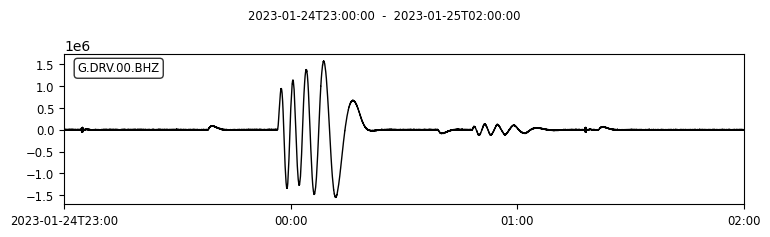

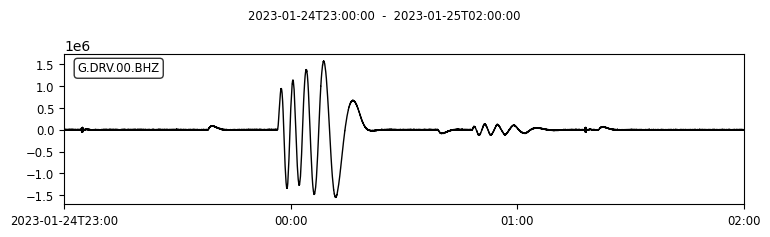

In [60]:
T.plot()

In [61]:
T.detrend("demean")
T.taper(type='hamming', max_percentage=0.05)
pre_filt = (0.005, 0.006, 30.0, 35.0)
#T.attach_response(inventory)
#T.remove_response()
T.remove_response(inventory=inventory, output='VEL', pre_filt=pre_filt)

G.DRV.00.BHZ | 2023-01-24T23:00:00.000000Z - 2023-01-25T02:00:00.000000Z | 20.0 Hz, 216001 samples

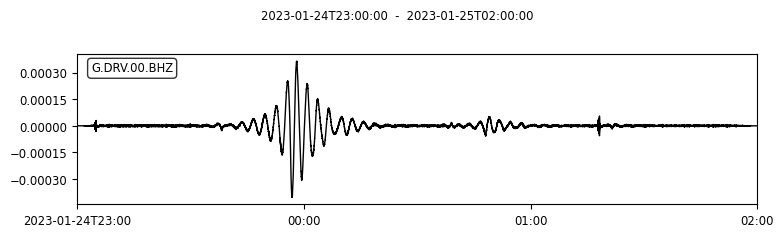

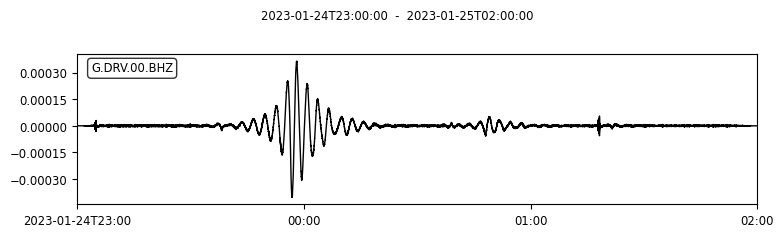

In [62]:
T.plot()

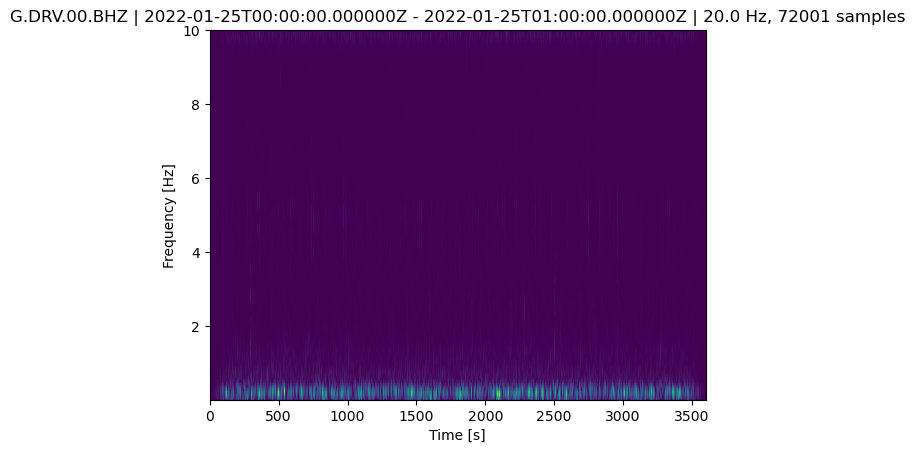

In [43]:
T.spectrogram()

In [13]:
help(obspy.imaging.spectrogram.spectrogram)

Help on function spectrogram in module obspy.imaging.spectrogram:

spectrogram(data, samp_rate, per_lap=0.9, wlen=None, log=False, outfile=None, fmt=None, axes=None, dbscale=False, mult=8.0, cmap=<matplotlib.colors.LinearSegmentedColormap object at 0x7f748d5db710>, zorder=None, title=None, show=True, clip=[0.0, 1.0])
    Computes and plots spectrogram of the input data.
    
    :param data: Input data
    :type samp_rate: float
    :param samp_rate: Samplerate in Hz
    :type per_lap: float
    :param per_lap: Percentage of overlap of sliding window, ranging from 0
        to 1. High overlaps take a long time to compute.
    :type wlen: int or float
    :param wlen: Window length for fft in seconds. If this parameter is too
        small, the calculation will take forever. If None, it defaults to a
        window length matching 128 samples.
    :type log: bool
    :param log: Logarithmic frequency axis if True, linear frequency axis
        otherwise.
    :type outfile: str
    :para

### Important parameters :
- `per lap` : overlap or not the windows for which the spectrum in amplitudes are calculated
- `wlen` : duration of the windows for which the the spectrum in amplitudes are calculated
- `dbscale` : colorscale based on decibels (log scale) instead of amplitude
- `clip` : define the color limits

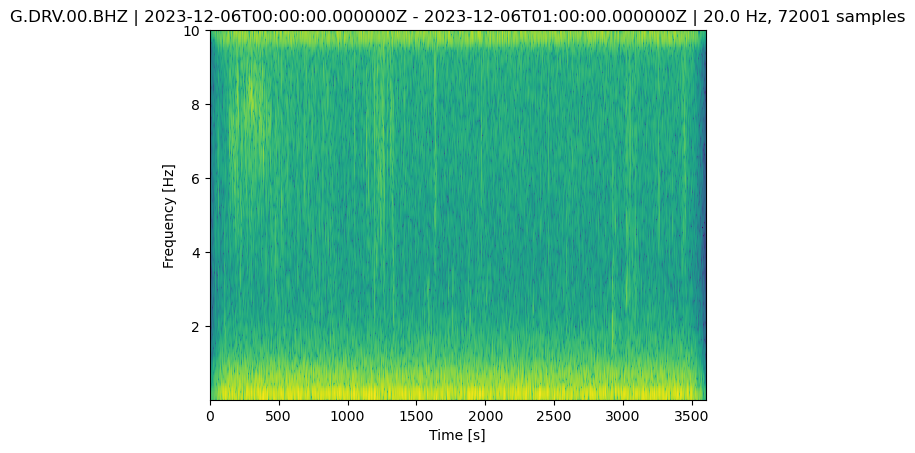

In [14]:
T.spectrogram(dbscale=True)

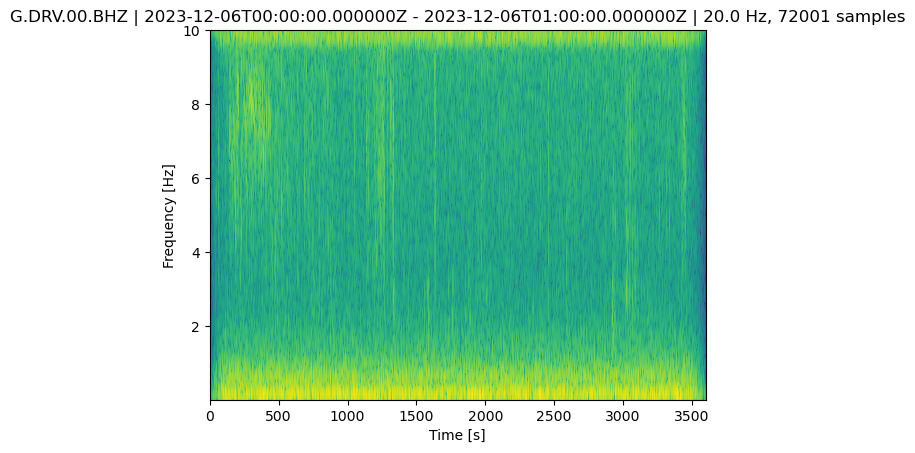

In [15]:
T.spectrogram(per_lap=.5, dbscale=True)

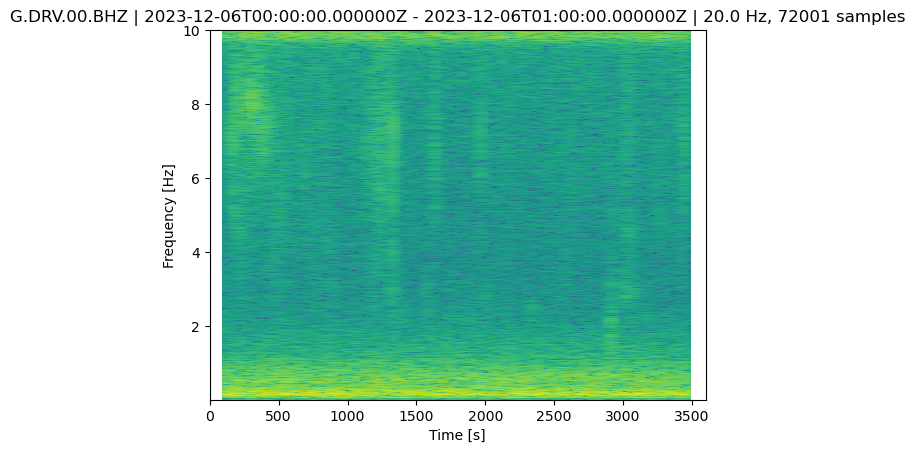

In [16]:
T.spectrogram(wlen=256, dbscale=True)

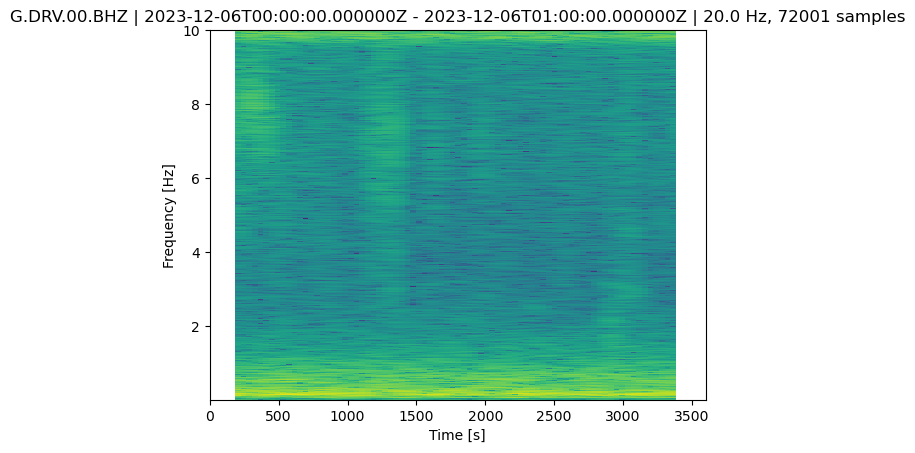

In [17]:
T.spectrogram(wlen=512, dbscale=True)

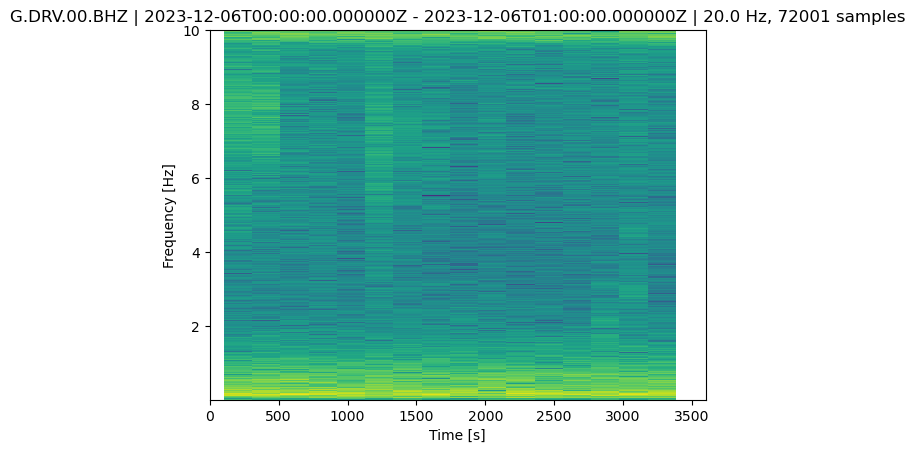

In [18]:
T.spectrogram(per_lap=.5, wlen=512, dbscale=True)

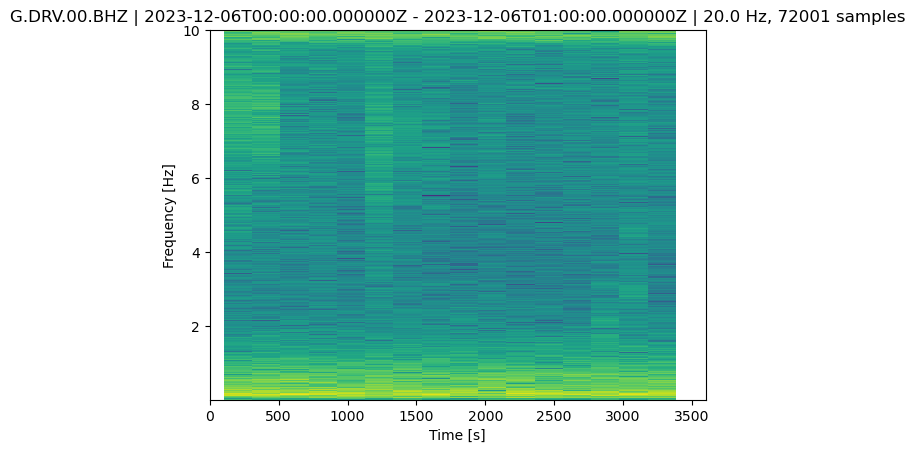

In [19]:
T.spectrogram(per_lap=.5, wlen=512, dbscale=True)

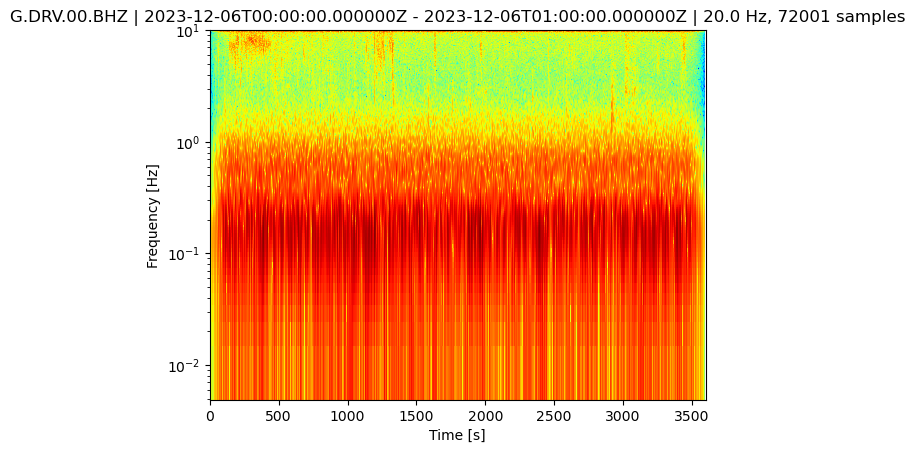

In [20]:
T.spectrogram(per_lap=.9, wlen=10, dbscale=True, log=True, cmap='jet')

## Spectrogramms with Scipy

In [21]:
import scipy.signal

In [22]:
help(scipy.signal.spectrogram)

Help on function spectrogram in module scipy.signal._spectral_py:

spectrogram(x, fs=1.0, window=('tukey', 0.25), nperseg=None, noverlap=None, nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=-1, mode='psd')
    Compute a spectrogram with consecutive Fourier transforms.
    
    Spectrograms can be used as a way of visualizing the change of a
    nonstationary signal's frequency content over time.
    
    Parameters
    ----------
    x : array_like
        Time series of measurement values
    fs : float, optional
        Sampling frequency of the `x` time series. Defaults to 1.0.
    window : str or tuple or array_like, optional
        Desired window to use. If `window` is a string or tuple, it is
        passed to `get_window` to generate the window values, which are
        DFT-even by default. See `get_window` for a list of windows and
        required parameters. If `window` is array_like it will be used
        directly as the window and its length 

In [63]:
wlen = 100
per_lap = .8

nperseg = round(wlen * T.stats.sampling_rate)
noverlap = round(nperseg*per_lap)
f, t, Sxx = scipy.signal.spectrogram(x=T.data, fs=T.stats.sampling_rate, nperseg=nperseg, noverlap=noverlap)

In [64]:
fmin, fmax = .01, 10

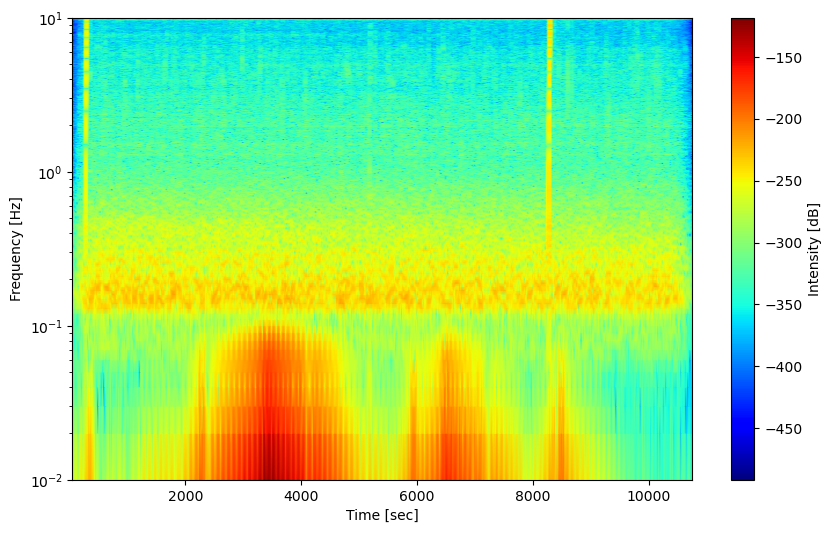

In [65]:
plt.figure(figsize=(10, 6), dpi=100)
plt.pcolormesh(t, f, np.log(Sxx)*10, shading='gouraud', cmap='jet')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.yscale('log')
plt.ylim(fmin, fmax)
plt.colorbar(label='Intensity [dB]')

In [26]:
fmin, fmax = 1, 10
ii = np.where((f >= fmin) & (f <= fmax))

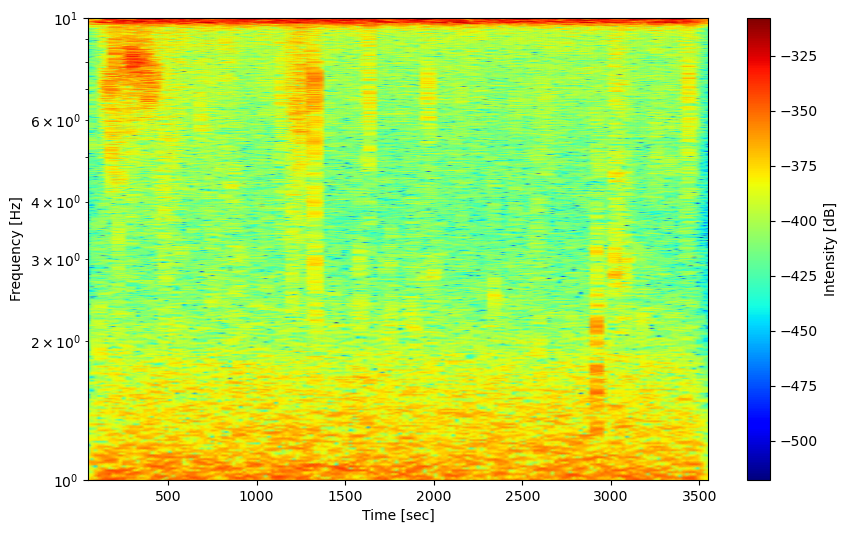

In [27]:
plt.figure(figsize=(10, 6), dpi=100)
plt.pcolormesh(t, f[ii], np.log(Sxx[ii])*10, shading='gouraud', cmap='jet')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.yscale('log')
plt.ylim(fmin, fmax)
plt.colorbar(label='Intensity [dB]')

In [28]:
Tmin, Tmax = 10, 100 # Filtre basse fréquence : séismes ?
fmin, fmax = 1/Tmax, 1/Tmin
ii = np.where((f >= fmin) & (f <= fmax))

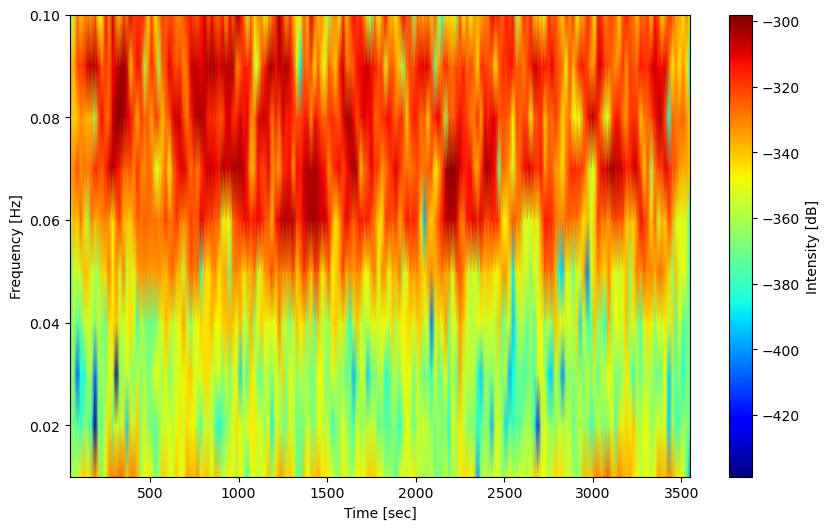

In [29]:
plt.figure(figsize=(10, 6), dpi=100)
plt.pcolormesh(t, f[ii], np.log(Sxx[ii])*10, shading='gouraud', cmap='jet')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
#plt.yscale('log')
plt.ylim(fmin, fmax)
plt.colorbar(label='Intensity [dB]')

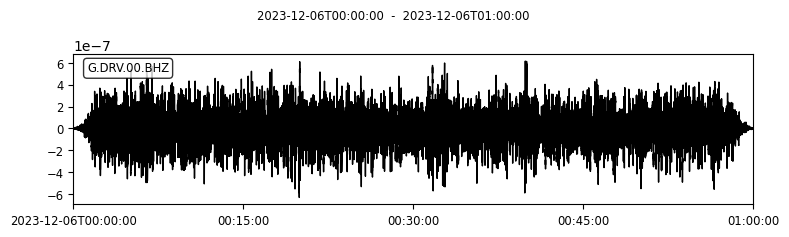

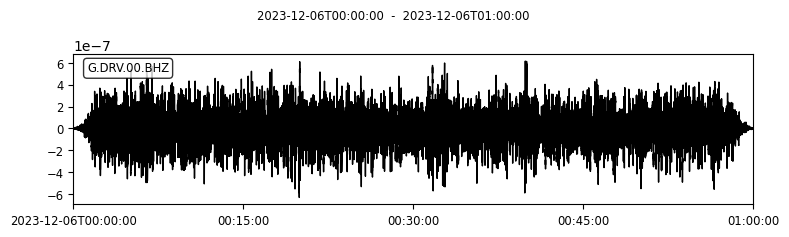

In [30]:
T.plot()

/home/valentin/micromamba/envs/obspy/lib/python3.11/site-packages/scipy/signal/_spectral_py.py:2017: UserWarning: nperseg = 500 is greater than input length  = 0, using nperseg = 0
  warnings.warn('nperseg = {0:d} is greater than input length '


ValueError: not enough values to unpack (expected 2, got 1)

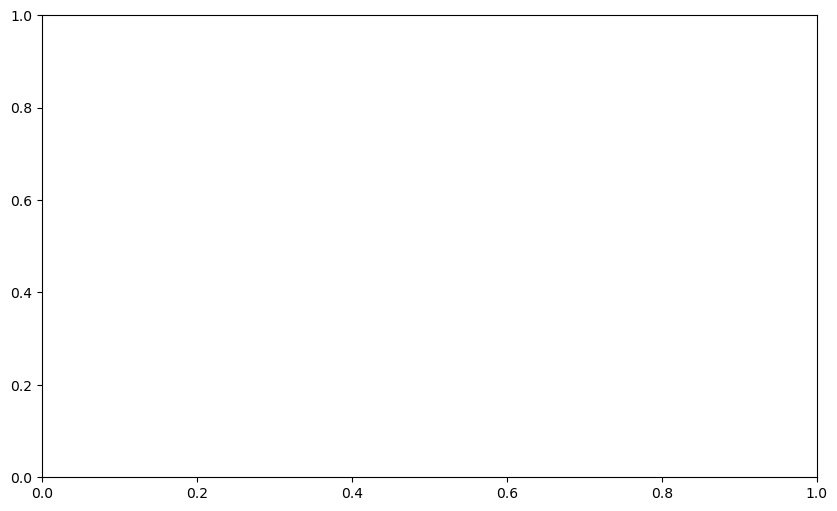

In [31]:
size = 36000
Sxx_min, Sxx_max = -80, 60

k = 9
i1 = k*size
i2 = (k+1)*size
data = T.data[i1:i2]
f, t, Sxx = scipy.signal.spectrogram(x=data, fs=T.stats.sampling_rate, nperseg=500, noverlap=250)

fig = plt.figure(figsize=(10, 6), dpi=100)
plt.pcolormesh(t, f, 10*np.log10(Sxx), shading='gouraud', cmap='jet') #, vmin=Sxx_min, vmax=Sxx_max
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar(label='Intensity [dB]')
plt.tight_layout()

In [ ]:
t

In [ ]:
fig = plt.figure(figsize=(10, 6), dpi=100)
plt.pcolormesh(t, f, 10*np.log10(Sxx), shading='gouraud', cmap='jet') #, vmin=Sxx_min, vmax=Sxx_max
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar(label='Intensity [dB]')
plt.tight_layout()

In [35]:
year = 2022
for m in range(1, 13):
    for n in [1, 5, 10, 15, 20, 25]:
        for day in [0, 6, 12, 18]:
            try:
                starttime = UTCDateTime(2023,m,n,day,0,0)
                endtime = starttime + 60*60
                st = client.get_waveforms(network='G', station='DRV', location='*', channel='BHZ', starttime=starttime, endtime=endtime)
                T = st[0]
                T.detrend("demean")
                T.taper(type='hamming', max_percentage=0.05)
                pre_filt = (0.005, 0.006, 30.0, 35.0)
                T.remove_response(inventory=inventory, output='VEL', pre_filt=pre_filt)
                
                wlen = 100
                per_lap = .8
                fmin, fmax = .01, 10
                ii = np.where((f >= fmin) & (f <= fmax))
                nperseg = round(wlen * T.stats.sampling_rate)
                noverlap = round(nperseg*per_lap)
                f, t, Sxx = scipy.signal.spectrogram(x=T.data, fs=T.stats.sampling_rate, nperseg=nperseg, noverlap=noverlap)
                plt.figure(figsize=(10, 6), dpi=100)
                plt.pcolormesh(t, f[ii], np.log(Sxx[ii])*10, shading='gouraud', cmap='jet')
                plt.ylabel('Frequency [Hz]')
                plt.xlabel('Time [sec]')
                plt.yscale('log')
                plt.ylim(fmin, fmax)
                plt.colorbar(label='Intensity [dB]')
                plt.savefig(f'out/{year}_{m}_{n}_{day}_GLO.png')
                plt.clf()
                
                wlen = 10
                per_lap = .8
                nperseg = round(wlen * T.stats.sampling_rate)
                noverlap = round(nperseg*per_lap)
                f, t, Sxx = scipy.signal.spectrogram(x=T.data, fs=T.stats.sampling_rate, nperseg=nperseg, noverlap=noverlap)
                fmin, fmax = 1, 10
                ii = np.where((f >= fmin) & (f <= fmax))
                plt.figure(figsize=(10, 6), dpi=100)
                plt.pcolormesh(t, f[ii], np.log(Sxx[ii])*10, shading='gouraud', cmap='jet')
                plt.ylabel('Frequency [Hz]')
                plt.xlabel('Time [sec]')
                plt.ylim(fmin, fmax)
                plt.colorbar(label='Intensity [dB]')
                plt.savefig(f'out/HF/{year}_{m}_{n}_{day}_HF.png')
                plt.clf()
                
                wlen = 1000
                per_lap = .8
                nperseg = round(wlen * T.stats.sampling_rate)
                noverlap = round(nperseg*per_lap)
                f, t, Sxx = scipy.signal.spectrogram(x=T.data, fs=T.stats.sampling_rate, nperseg=nperseg, noverlap=noverlap)
                Tmin, Tmax = 10, 100 # Filtre basse fréquence : séismes ?
                fmin, fmax = 1/Tmax, 1/Tmin
                ii = np.where((f >= fmin) & (f <= fmax))
                plt.figure(figsize=(10, 6), dpi=100)
                plt.pcolormesh(t, f[ii], np.log(Sxx[ii])*10, shading='gouraud', cmap='jet')
                plt.ylabel('Frequency [Hz]')
                plt.xlabel('Time [sec]')
                plt.ylim(fmin, fmax)
                plt.colorbar(label='Intensity [dB]')
                plt.savefig(f'out/BF/{year}_{m}_{n}_{day}_BF.png')
                plt.clf()
                
                print('ok', m, n, day)
            except Exception as e:
                print(m, n, day, e)

ok 1 1 0
1 1 6 index 1001 is out of bounds for axis 0 with size 1001
ok 1 1 12
1 1 18 index 1001 is out of bounds for axis 0 with size 1001
ok 1 5 0
1 5 6 index 1001 is out of bounds for axis 0 with size 1001
ok 1 5 12
1 5 18 index 1001 is out of bounds for axis 0 with size 1001
ok 1 10 0
1 10 6 index 1001 is out of bounds for axis 0 with size 1001


/tmp/ipykernel_13790/864628610.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(10, 6), dpi=100)


ok 1 10 12
1 10 18 index 1001 is out of bounds for axis 0 with size 1001
ok 1 15 0
1 15 6 index 1001 is out of bounds for axis 0 with size 1001
ok 1 15 12
1 15 18 index 1001 is out of bounds for axis 0 with size 1001
ok 1 20 0
1 20 6 index 1001 is out of bounds for axis 0 with size 1001
ok 1 20 12
1 20 18 index 1001 is out of bounds for axis 0 with size 1001
ok 1 25 0
1 25 6 index 1001 is out of bounds for axis 0 with size 1001
ok 1 25 12
1 25 18 index 1001 is out of bounds for axis 0 with size 1001
ok 2 1 0
2 1 6 index 1001 is out of bounds for axis 0 with size 1001
ok 2 1 12
2 1 18 index 1001 is out of bounds for axis 0 with size 1001
ok 2 5 0
2 5 6 index 1001 is out of bounds for axis 0 with size 1001
ok 2 5 12
2 5 18 index 1001 is out of bounds for axis 0 with size 1001
ok 2 10 0
2 10 6 index 1001 is out of bounds for axis 0 with size 1001
ok 2 10 12
2 10 18 index 1001 is out of bounds for axis 0 with size 1001
ok 2 15 0
2 15 6 index 1001 is out of bounds for axis 0 with size 1001


ok 11 1 0
11 1 6 index 1001 is out of bounds for axis 0 with size 1001
ok 11 1 12
11 1 18 index 1001 is out of bounds for axis 0 with size 1001
ok 11 5 0
11 5 6 index 1001 is out of bounds for axis 0 with size 1001
ok 11 5 12
11 5 18 index 1001 is out of bounds for axis 0 with size 1001
ok 11 10 0
11 10 6 index 1001 is out of bounds for axis 0 with size 1001
ok 11 10 12
11 10 18 index 1001 is out of bounds for axis 0 with size 1001
ok 11 15 0
11 15 6 index 1001 is out of bounds for axis 0 with size 1001
ok 11 15 12
11 15 18 index 1001 is out of bounds for axis 0 with size 1001
ok 11 20 0
11 20 6 index 1001 is out of bounds for axis 0 with size 1001
ok 11 20 12
11 20 18 index 1001 is out of bounds for axis 0 with size 1001
ok 11 25 0
11 25 6 index 1001 is out of bounds for axis 0 with size 1001
ok 11 25 12
11 25 18 index 1001 is out of bounds for axis 0 with size 1001
ok 12 1 0
12 1 6 index 1001 is out of bounds for axis 0 with size 1001
ok 12 1 12
12 1 18 index 1001 is out of bounds fo

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [ ]:
3 3 22